In [ ]:
names = "./dataset_sleep/0.8/0.8/0.csv"
raw_data = pd.read_csv(names)
unwsig = raw_data
new = process(unwsig)
new

### Function

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
import combine_svm
import pandas as pd
from tqdm import tqdm
import csv
import scipy.signal
from scipy.fftpack import fft
import seaborn as sns
sns.set()
''' ----------------------- Movement ----------------------- '''
# 30s訊號 = 30 * 20 = 600
def mov_dens_fn(raw_sig):
    new_sig = []
    count = 0
    for num in range(80):
        top = 0
        first = int(num*(0.5*20))
        last = int((num+1)*(0.5*20))
        x = raw_sig[first:last]

        # 方差公式
        for i in range(10):
            top += np.square(x[i] - np.average(x))
        result = top / (10 - 1)
        if result > 0.005:  # 閥值可調
            count += 1
    percent = (count/80) * 100
    return percent

''' ----------------------- Respiration ----------------------- '''
# 10個fRSA
def tfRSA_fn(fRSA_sig):
    tfRSA = np.std(fRSA_sig)
    return tfRSA

# 31個f𝑅𝑆𝐴
def sfRSA_fn(fRSA_sig):
    sfRSA = scipy.signal.savgol_filter(fRSA_sig, 31, 3)
    sfRSA_mean = np.average(sfRSA)
    return sfRSA, sfRSA_mean

# 31個tf𝑅𝑆𝐴
def stfRSA_fn(tfRSA_sig):
    stfRSA = scipy.signal.savgol_filter(np.array(tfRSA_sig), 31, 2)
    stfRSA_mean = np.average(stfRSA)
    return stfRSA, stfRSA_mean

# 31個f𝑅𝑆𝐴
def sdfRSA_fn(fRSA, sfRSA):
    sdfRSA = np.abs(fRSA - sfRSA)
    sdfRSA = scipy.signal.savgol_filter(sdfRSA, 31, 3)
    sdfRSA_mean = np.average(sdfRSA)
    return sdfRSA, sdfRSA_mean

''' ----------------------- Heart rate ----------------------- '''
def tmHR_fn(mHR_sig):
    return tfRSA_fn(mHR_sig)

def smHR_fn(mHR_sig):
    return sfRSA_fn(mHR_sig)

def stmHR_fn(tmHR_sig):
    return stfRSA_fn(tmHR_sig)

def sdmHR_fn(mHR, smHR):
    return sdfRSA_fn(mHR, smHR)

# ---------------- 待補 ---------------- 
def LF_HF_LFHF(sig):
    LF_sig = combine_svm.iir_bandpass_filter_1(sig, 0.04, 0.15, 20, 9, "cheby2")
    HF_sig = combine_svm.iir_bandpass_filter_1(sig, 0.15, 0.4, 20, 9, "cheby2")
    print(LF_sig)
    LF_eng = energe(LF_sig)
    HF_eng = energe(HF_sig)
    LFHF_eng = HF_eng / LF_eng
    return LF_eng, HF_eng, LFHF_eng

def energe(sig):
    N = len(sig)
    bps_fft = np.fft.fft(sig)
    return np.sum(np.abs(bps_fft[:N // 2])**2)

def sHF_fn(HF_sig):
    sHF = scipy.signal.savgol_filter(HF_sig, 31, 3)
    sHF_mean = np.average(sfRSA)
    return sHF, sHF_mean

def sLFHF_fn(LFHF_sig):
    sLFHF = scipy.signal.savgol_filter(LFHF_sig, 31, 3)
    sLFHF_mean = np.average(sfRSA)
    return sLFHF, sLFHF_mean


### 讀所有資料

In [ ]:
names = "./dataset_sleep"
for name in os.listdir(names):
    files = os.path.join(names, name, "0.8")
    for num in range(len(os.listdir(files)) // 2):
        datas = os.listdir(files)[num]
        data = os.path.join(files, datas)
        raw_data = pd.read_csv(data)
        raw_data_pd = pd.DataFrame(raw_data)
raw_data_pd.info()

## LF HF LFHF

In [6]:
def process(raw_data_pd):
    raw_data_pd = raw_data_pd.dropna()
    unwsig = raw_data_pd["unwrapPhasePeak_mm"]
    local_LF = []
    local_HF = []
    local_LFHF = []
    num_in_window = 20*60*5

    # 空值補0
    for i in range(num_in_window-1):
        local_LF.append(0)
        local_HF.append(0)
        local_LFHF.append(0)

    for turn in tqdm(range(len(unwsig) - num_in_window + 1)):
        start_index = turn
        end_index = start_index + num_in_window

        # Slide data
        window_unwsig = unwsig[start_index:end_index]
        LF, HF, LFHF = LF_HF_LFHF(window_unwsig)
        local_LF.append(LF)
        local_HF.append(HF)
        local_LFHF.append(LFHF)

    raw_data_pd.insert(39, "LF", local_LF)
    raw_data_pd.insert(40, "HF", local_HF)
    raw_data_pd.insert(41, "LFHF", local_LFHF)
    return raw_data_pd
    # print(raw_data_pd)


### 只取有心律跟呼吸律的時間點，把特徵單位轉成秒

In [5]:
# 特徵單位變成秒
raw_data_pd['heart'] = raw_data_pd['heart'].replace(0, np.nan)
new_data = raw_data_pd.dropna()
new_data.head(-10)

,rangeBinIndexMax,rangeBinIndexPhase,maxVal,processingCyclesOut,processingCyclesOut1,rangeBinStartIndex,rangeBinEndIndex,unwrapPhasePeak_mm,outputFilterBreathOut,outputFilterHeartOut,...,rsv[4],rsv[5],rsv[6],rsv[7],rsv[8],rsv[9],datetime,heart,breath,sleep
0,0,25,678702080.0,9240,0,11,73,46.011349,-0.030982,0.032569,...,0.0,0.0,0.0,0.0,0.0,0.0,00:37:04,99.0762,15.1772,5
20,0,25,205501712.0,9239,0,11,73,45.460480,-0.038355,0.107341,...,0.0,0.0,0.0,0.0,0.0,0.0,00:37:05,85.1557,15.3148,5
40,0,25,266188288.0,9239,0,11,73,45.611523,0.066577,0.120520,...,0.0,0.0,0.0,0.0,0.0,0.0,00:37:06,85.4725,15.1785,5
60,0,25,560289792.0,9241,0,11,73,46.231041,-0.008990,-0.033685,...,0.0,0.0,0.0,0.0,0.0,0.0,00:37:07,94.9775,15.2181,5
80,0,25,705112064.0,9240,0,11,73,46.098312,-0.039136,-0.018482,...,0.0,0.0,0.0,0.0,0.0,0.0,00:37:08,85.7710,15.1200,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571684,0,29,82135224.0,9245,0,11,73,235.426819,0.261165,-1.115831,...,0.0,0.0,0.0,0.0,0.0,0.0,08:33:29,82.6045,16.9453,5
571704,0,29,190133280.0,9245,0,11,73,241.079987,-0.308572,0.695556,...,0.0,0.0,0.0,0.0,0.0,0.0,08:33:30,83.5118,17.0098,5
571724,0,29,335490048.0,9241,0,11,73,241.407562,-0.304765,-0.151951,...,0.0,0.0,0.0,0.0,0.0,0.0,08:33:31,82.8463,17.0684,5
571744,0,31,467103360.0,9269,0,11,73,242.203552,-0.174935,0.020348,...,0.0,0.0,0.0,0.0,0.0,0.0,08:33:32,82.0375,16.9365,5


### 特徵: tfRSA, tmHR, sfRSA, smHR, sdfRSA, sdmHR

In [5]:
breath = np.array(new_data['breath'])
heart = np.array(new_data['heart'])
print(f"Total len: {len(heart)}\n")

# ------------- tfRSA and tmHR ------------- 
local_tfRSA = []
local_tmHR = []
num_in_window = 10

# 空值補0
for i in range(num_in_window-1):
    local_tfRSA.append(0)
    local_tmHR.append(0)

for turn in range(len(breath) - num_in_window + 1):
    start_index = turn
    end_index = start_index + num_in_window

    # Slide data
    window_breath = breath[start_index:end_index]
    window_heart = heart[start_index:end_index]

    # Standard deviation
    local_tfRSA.append(str(round(tfRSA_fn(window_breath), 4)))
    local_tmHR.append(str(round(tmHR_fn(window_heart), 4)))

print("tfRSA and tmHR Complete!")
print(f"Real len: {len(breath)}\ntfRSA len: {len(local_tfRSA)}\ntmHR len: {len(local_tmHR)}")

#  ------------- sfRSA and smHR and sdfRSA and sdmHR------------- 
local_sfRSA = []
local_sdfRSA = []
local_smHR = []
local_sdmHR = []
num_in_window = 31

# 空值補0
for i in range(num_in_window-1):
    local_sfRSA.append(0)
    local_smHR.append(0)
    local_sdfRSA.append(0)
    local_sdmHR.append(0)

for turn in range(len(breath) - num_in_window + 1):
    start_index = turn
    end_index = start_index + num_in_window

    # Slide data
    window_breath = breath[start_index:end_index]
    window_heart = heart[start_index:end_index]

    # Savitzky–Golay filter
    sfRSA, sfRSA_mean = sfRSA_fn(window_breath)
    sdfRSA, sdfRSA_mean = sdfRSA_fn(window_breath, sfRSA)
    smHR, smHR_mean = smHR_fn(window_heart)
    sdmHR, sdmHR_mean = sdmHR_fn(window_heart, smHR)
    local_sfRSA.append(round(sfRSA_mean, 4))
    local_sdfRSA.append(round(sdfRSA_mean, 4))
    local_smHR.append(round(smHR_mean, 4))
    local_sdmHR.append(round(sdmHR_mean, 4))

print("\nsfRSA and smHR Complete!")
print(f"Real len: {len(heart)}\nsfRSA len: {len(local_sfRSA)}\nsmHR len: {len(local_smHR)}")

# 插入特徵
new_data.insert(39, "tfRSA", local_tfRSA)
new_data.insert(40, "tmHR", local_tmHR)
new_data.insert(41, "sfRSA", local_sfRSA)
new_data.insert(42, "smHR", local_smHR)
new_data.insert(43, "sdfRSA", local_sdfRSA)
new_data.insert(44, "sdmHR", local_sdmHR)
new_data.head(10)

Total len: 28600

tfRSA and tmHR Complete!
Real len: 28600
tfRSA len: 28600
tmHR len: 28600

sfRSA and smHR Complete!
Real len: 28600
sfRSA len: 28600
smHR len: 28600


,rangeBinIndexMax,rangeBinIndexPhase,maxVal,processingCyclesOut,processingCyclesOut1,rangeBinStartIndex,rangeBinEndIndex,unwrapPhasePeak_mm,outputFilterBreathOut,outputFilterHeartOut,...,datetime,heart,breath,sleep,tfRSA,tmHR,sfRSA,smHR,sdfRSA,sdmHR
0,0,25,678702080.0,9240,0,11,73,46.011349,-0.030982,0.032569,...,00:37:04,99.0762,15.1772,5,0,0,0.0,0.0,0.0,0.0
20,0,25,205501712.0,9239,0,11,73,45.460480,-0.038355,0.107341,...,00:37:05,85.1557,15.3148,5,0,0,0.0,0.0,0.0,0.0
40,0,25,266188288.0,9239,0,11,73,45.611523,0.066577,0.120520,...,00:37:06,85.4725,15.1785,5,0,0,0.0,0.0,0.0,0.0
60,0,25,560289792.0,9241,0,11,73,46.231041,-0.008990,-0.033685,...,00:37:07,94.9775,15.2181,5,0,0,0.0,0.0,0.0,0.0
80,0,25,705112064.0,9240,0,11,73,46.098312,-0.039136,-0.018482,...,00:37:08,85.7710,15.1200,5,0,0,0.0,0.0,0.0,0.0
100,0,27,343612064.0,9237,0,11,73,47.363541,0.048572,0.071868,...,00:37:09,86.0495,15.2137,5,0,0,0.0,0.0,0.0,0.0
120,0,27,517794016.0,9243,0,11,73,47.487911,-0.034216,0.041764,...,00:37:10,86.2745,15.3411,5,0,0,0.0,0.0,0.0,0.0
140,0,27,411774464.0,9246,0,11,73,47.898235,-0.001481,0.031011,...,00:37:11,85.3284,15.4876,5,0,0,0.0,0.0,0.0,0.0
160,0,27,201903104.0,9245,0,11,73,47.122631,-0.024752,-0.026941,...,00:37:12,87.6868,15.6341,5,0,0,0.0,0.0,0.0,0.0
180,0,27,467913376.0,9244,0,11,73,47.540710,0.045621,0.128608,...,00:37:13,86.7550,15.6532,5,0.184,4.5358,0.0,0.0,0.0,0.0


### 為了要算 stfRSA and stmHR 將特徵單位變成tmHR

In [6]:
# 特徵單位變成tmHR
new_data['tmHR'] = new_data['tmHR'].replace(0, np.nan)
new_data = new_data.dropna()
new_data

C:\Users\story\AppData\Local\Temp/ipykernel_13600/2832778280.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['tmHR'] = new_data['tmHR'].replace(0, np.nan)


,rangeBinIndexMax,rangeBinIndexPhase,maxVal,processingCyclesOut,processingCyclesOut1,rangeBinStartIndex,rangeBinEndIndex,unwrapPhasePeak_mm,outputFilterBreathOut,outputFilterHeartOut,...,datetime,heart,breath,sleep,tfRSA,tmHR,sfRSA,smHR,sdfRSA,sdmHR
180,0,27,467913376.0,9244,0,11,73,47.540710,0.045621,0.128608,...,00:37:13,86.7550,15.6532,5,0.184,4.5358,0.0000,0.0000,0.0000,0.0000
200,0,27,194499984.0,9250,0,11,73,47.912174,0.016954,0.006518,...,00:37:14,87.8431,15.6663,5,0.2001,2.7601,0.0000,0.0000,0.0000,0.0000
220,0,27,281154336.0,9252,0,11,73,47.686138,-0.023318,0.021087,...,00:37:15,87.7074,15.6326,5,0.2117,2.6825,0.0000,0.0000,0.0000,0.0000
240,0,27,475787840.0,9253,0,11,73,47.664837,0.001510,-0.035739,...,00:37:16,88.2405,15.6546,5,0.2068,2.6126,0.0000,0.0000,0.0000,0.0000
260,0,27,254279808.0,9245,0,11,73,47.744019,0.016174,-0.064278,...,00:37:17,89.1838,15.7220,5,0.2025,1.1711,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571884,0,31,83358848.0,9249,0,11,73,234.399231,-0.025608,0.003533,...,08:33:39,85.0522,16.5601,5,0.1914,0.9851,16.3743,81.4335,0.0456,0.6788
571904,0,31,89054000.0,9249,0,11,73,234.500763,-0.059772,-0.001135,...,08:33:40,85.8378,16.5894,5,0.1786,1.2057,16.4410,81.7034,0.0446,0.6290
571924,0,31,91730328.0,9247,0,11,73,234.420593,-0.062082,0.025901,...,08:33:41,85.2927,16.6187,5,0.1378,1.2446,16.5022,82.0116,0.0453,0.6299
571944,0,31,99052720.0,9250,0,11,73,234.395233,-0.033079,0.009713,...,08:33:42,85.1736,16.5659,5,0.1103,1.0977,16.5550,82.2474,0.0426,0.6406


### 特徵: stfRSA and stmHR

In [7]:
tfRSA = np.array(new_data['tfRSA'])
tmHR = np.array(new_data['tmHR'])

#  ------------- stfRSA and stmHR ------------- 
local_stfRSA = []
local_stmHR = []
num_in_window = 31

# 空值補0
for i in range(num_in_window-1):
    local_stfRSA.append(0)
    local_stmHR.append(0)

for turn in range(len(tfRSA) - num_in_window + 1):
    start_index = turn
    end_index = start_index + num_in_window

    # Slide data
    window_tfRSA = tfRSA[start_index:end_index]
    window_tmHR = tmHR[start_index:end_index]

    # Savitzky–Golay filter
    stfRSA, stfRSA_mean = stfRSA_fn(window_tfRSA)
    stmHR, stmHR_mean = stmHR_fn(window_tmHR)
    local_stfRSA.append(round(stfRSA_mean, 4))
    local_stmHR.append(round(stmHR_mean, 4))

new_data.insert(45, "stfRSA", local_stfRSA)
new_data.insert(46, "stmHR", local_stmHR)

print("\nsfRSA and smHR Complete!")
print(f"Real len: {len(heart)}\nstfRSA len: {len(local_stfRSA)}\nstmHR len: {len(local_stmHR)}")


sfRSA and smHR Complete!
Real len: 28600
stfRSA len: 28591
stmHR len: 28591


### 只保留不為零的特徵

In [8]:
# 只保留不為零的特徵
new_data['stmHR'] = new_data['stmHR'].replace(0, np.nan)
new_data = new_data.dropna()
new_data

,rangeBinIndexMax,rangeBinIndexPhase,maxVal,processingCyclesOut,processingCyclesOut1,rangeBinStartIndex,rangeBinEndIndex,unwrapPhasePeak_mm,outputFilterBreathOut,outputFilterHeartOut,...,breath,sleep,tfRSA,tmHR,sfRSA,smHR,sdfRSA,sdmHR,stfRSA,stmHR
780,0,27,176620464.0,9253,0,11,73,47.228394,-0.005012,0.004266,...,20.3201,5,0.7821,1.4857,17.2172,80.4244,0.0381,1.3623,0.3776,2.5013
800,0,27,208052960.0,9255,0,11,73,46.808144,0.008850,0.090278,...,20.5545,5,0.7832,1.0809,17.3753,79.9605,0.0405,1.3478,0.3969,2.3898
820,0,27,126948264.0,9252,0,11,73,47.046898,0.008301,0.064517,...,20.7246,5,0.7609,1.0404,17.5385,79.4326,0.0464,1.3407,0.4150,2.3344
840,0,27,287388256.0,9251,0,11,73,47.251350,0.007309,0.025997,...,20.9604,5,0.7317,2.7668,17.7103,78.6836,0.0499,1.5867,0.4318,2.3371
860,0,27,301873440.0,9240,0,11,73,46.777557,-0.039243,0.034807,...,21.2051,5,0.7082,3.3534,17.8894,77.9489,0.0491,1.5981,0.4480,2.3610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571884,0,31,83358848.0,9249,0,11,73,234.399231,-0.025608,0.003533,...,16.5601,5,0.1914,0.9851,16.3743,81.4335,0.0456,0.6788,0.2897,1.2802
571904,0,31,89054000.0,9249,0,11,73,234.500763,-0.059772,-0.001135,...,16.5894,5,0.1786,1.2057,16.4410,81.7034,0.0446,0.6290,0.2906,1.2636
571924,0,31,91730328.0,9247,0,11,73,234.420593,-0.062082,0.025901,...,16.6187,5,0.1378,1.2446,16.5022,82.0116,0.0453,0.6299,0.2890,1.2497
571944,0,31,99052720.0,9250,0,11,73,234.395233,-0.033079,0.009713,...,16.5659,5,0.1103,1.0977,16.5550,82.2474,0.0426,0.6406,0.2848,1.2297


In [9]:
new_data.to_csv("./sleep_features/test01.csv", index=False)
print("Completed!")

Completed!


# Extraction Feature

In [10]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

In [11]:
""" 讀入資料 """
data_path = "./sleep_features/test01.csv"
total_data = pd.read_csv(data_path)
x = pd.DataFrame(total_data[["heart", "breath", "tfRSA", "tmHR", "sfRSA", "smHR", "sdfRSA", "sdmHR", "stfRSA", "stmHR"]])
y = pd.DataFrame(total_data[["sleep"]])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.5, random_state=42)
print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (13770, 10)
Testing shape: (13771, 10)


In [44]:
randomForestModel = RandomForestClassifier(n_estimators = 100, random_state = 69, n_jobs = -1, min_samples_leaf = 3, min_samples_split = 5)
randomForestModel.fit(X_train, y_train)
predicted = randomForestModel.predict(X_train)
print(predicted)

C:\Users\story\AppData\Local\Temp/ipykernel_1004/3128165743.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randomForestModel.fit(X_train, y_train)


[3 3 3 ... 4 5 3]


In [45]:
print("訓練: ", randomForestModel.score(X_train, y_train))
print("測試: ", randomForestModel.score(X_test, y_test))

訓練:  0.9926456793366103
測試:  0.8593512560268652


特徵重要度:  [0.09692072 0.11694161 0.06434145 0.07551982 0.14313018 0.11579252
 0.08331046 0.0886725  0.1176227  0.09774805]


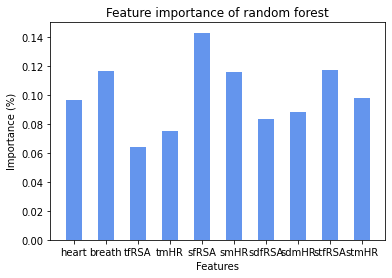

In [84]:
print("特徵重要度: ", randomForestModel.feature_importances_)
plt.figure()
plt.bar(["heart", "breath", "tfRSA", "tmHR", "sfRSA", "smHR", "sdfRSA", "sdmHR", "stfRSA", "stmHR"], 
        randomForestModel.feature_importances_, width=0.5, 
        color=['cornflowerblue'])
plt.title("Feature importance of random forest")
plt.xlabel("Features")
plt.ylabel("Importance (%)")
plt.show()

In [13]:
import joblib
joblib.dump(randomForestModel, "save/sleep_feature.pkl")

NameError: name 'randomForestModel' is not defined

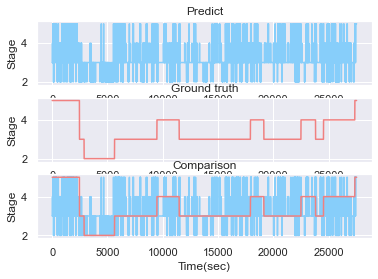

In [14]:
import matplotlib.pyplot as plt
model = joblib.load("save/sleep_feature.pkl")
predict = np.array(model.predict(x)).astype("uint64")
gt = np.array(np.squeeze(y))


plt.figure()
plt.subplot(3, 1, 1)
plt.plot(predict, color = "lightskyblue")
plt.title("Predict")
plt.xlabel("Time(sec)")
plt.ylabel("Stage")

plt.subplot(3, 1, 2)
plt.plot(gt, color = "lightcoral")
plt.title("Ground truth")
plt.xlabel("Time(sec)")
plt.ylabel("Stage")

plt.subplot(3, 1, 3)
plt.plot(predict, color = "lightskyblue")
plt.plot(gt, color = "lightcoral")
plt.title("Comparison")
plt.xlabel("Time(sec)")
plt.ylabel("Stage")
plt.show()


In [40]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators = 100, random_state = 69, n_jobs = -1, min_samples_leaf = 3, min_samples_split = 5)
scores = cross_val_score(rf, x, y, cv=2, scoring='accuracy')
print(scores)
print(scores.mean())

C:\Users\story\anaconda3\envs\mspl\lib\site-packages\sklearn\model_selection\_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\story\anaconda3\envs\mspl\lib\site-packages\sklearn\model_selection\_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[0.50124758 0.51874226]
0.5099949228210521


In [ ]:
plot_train = pd.DataFrame(X_train)
plot_train["class"] = y_train
plot_test = pd.DataFrame(X_test)
plot_test["class"] = y_test

In [15]:
ac = 0
for i in range(len(predict)):
    if predict[i] == gt[i]:
        ac +=1

print(ac / len(gt))

0.5242365927163138
